In [1]:
# Standard data science libraries
import pandas as pd
import copy
import numpy as np
from datetime import datetime
from sklearn.impute import SimpleImputer
# Visualization
import seaborn as sns
sns.set()
import matplotlib
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from countrygroups import EUROPEAN_UNION
import re
import os.path 
%matplotlib inline
import pycountry
from googletrans import Translator
import glob
import geopy

In [19]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')
EU_countries = EUROPEAN_UNION.names
path = "../data/Tripadvisor_datasets/*.csv"

In [20]:
def preprocessing(df):
    df['date'] = df['date'].replace({'Date of experience: ': ''}, regex=True)
    df['date'] = df['date'].replace({'Date of experience: ': ''}, regex=True)
    df['visit'] = df['visit'].replace({'Trip type: ': ''}, regex=True)
    df['date']= [datetime.strptime(date, '%B %Y')for date in df['date']]
    df = df.sort_values(by='date', ascending=False, inplace=False, ignore_index=True)
    #df['date'] = df['date'].dt.strftime('%Y-%m')
    df = df.set_index('date')
    

    return df

In [21]:
def clustering_process(df):
    df[['city', 'country']] = df['visitor_origin'].str.split(', ', expand=True, n=1)
    df = df.drop(['rating','title','text'], axis=1)
    return df

In [22]:
def get_season(df):
    summer_pre_covid = df[(df.index >= '2019-06-1') & (df.index <= '2019-08-01')]
    winter_pre_covid = df[(df.index >= '2019-09-1') & (df.index <= '2020-02-01')]
    winter_post_covid = df[(df.index >= '2020-03-01') & (df.index <= '2020-05-01')]
    summer_post_covid = df[(df.index >= '2020-06-01')]
    
    return summer_pre_covid, winter_pre_covid,winter_post_covid, summer_post_covid

In [23]:
def feature_extraction(df, file_name):
    df = preprocessing(df)
    df = clustering_process(df)
    visitors_by_country = df.groupby('country').count().sort_values('visit', ascending=True)
    type_of_visitors    = df.groupby('visit').count().sort_values('country', ascending=True)
    type_of_visitors    = type_of_visitors.T.drop(index=['city', 'country'])
    visitors_by_city    = df.groupby('city').count().sort_values('visit', ascending=True)
    type_of_visitors.index.rename(file_name)
    return visitors_by_country, type_of_visitors, visitors_by_city


In [24]:
def eu_countries(visitors_by_country): 
    visitors_by_country["Non EU"] = 0
    for i in range (len(visitors_by_country)):
        if not(visitors_by_country.index[i] in EU_countries):
            visitors_by_country["Non EU"][i] = int(1)
    return visitors_by_country

In [25]:
def get_visitors(visitors_by_country, visitors_by_city):
    
    visitors_from_munich    = visitors_by_city['visitor_origin']['Munich']
    visitors_outside_munich = visitors_by_country['visitor_origin']['Germany']- visitors_by_city['visitor_origin']['Munich']
    visitors_outside_eu     = visitors_by_country.groupby('Non EU').sum()['visitor_origin'][1]
    visitors_from_eu        = visitors_by_country.groupby('Non EU').sum()['visitor_origin'][0] - visitors_by_country['visitor_origin']['Germany']
    return visitors_from_munich, visitors_outside_munich, visitors_outside_eu, visitors_from_eu
    

In [26]:
def binary_encoding(df):
    df = preprocessing(df)
    df = clustering_process(df)
    df = df.reset_index()
    df['provenance'] = ''
    for index, row in df.iterrows():        
        if df['city'][index] == 'Munich':
            df['provenance'][index] = 'Munich'
        elif df['country'][index] == 'Germany' and df['city'][index] != 'Munich':
            df['provenance'][index] = 'outside Munich'
        elif df['country'][index] in EU_countries and df['country'][index] != 'Germany' : 
            df['provenance'][index] = 'EU apart from GER'
        else :
            df['provenance'][index] = 'Outisde EU'
    df = pd.get_dummies(df, columns=["provenance" , "visit"])
    df = df.set_index('date')

    return df

In [27]:
def get_file(path):
    file_names = []
    data = pd.DataFrame()
    names = glob.glob(path)
    for i in range (len(names)): 
        df = pd.read_csv(names[i],header=0, squeeze=True)
        file_name = os.path.basename(names[i])
        file_name = file_name.split('.')[0]
        file_names.append(file_name)
        visitors_by_country, type_of_visitors, visitors_by_city = feature_extraction(df, file_name)
        visitors_by_country = eu_countries (visitors_by_country)
        visitors_from_munich, visitors_outside_munich, visitors_outside_eu, visitors_from_eu = get_visitors(visitors_by_country, visitors_by_city)
        type_of_visitors['visitors_from_munich'] = visitors_from_munich
        type_of_visitors['visitors_outside_munich'] = visitors_outside_munich
        type_of_visitors['visitors_outside_eu'] = visitors_outside_eu
        type_of_visitors['visitors_from_eu'] = visitors_from_eu
        type_of_visitors['attraction_name'] = file_name
        data = data.append(type_of_visitors)
        
        print("Attraction %s is being processed..." % (str(file_name)))
    data.reset_index()
    data.set_index('attraction_name' , inplace=True)
    data[['Traveled on business' , 'Traveled solo' , 'Traveled with friends' , 'Traveled as a couple' , 'Traveled with family'  ]] = data[['Traveled on business' , 'Traveled solo' , 'Traveled with friends' , 'Traveled as a couple' , 'Traveled with family'  ]].div(data[['Traveled on business' , 'Traveled solo' , 'Traveled with friends' , 'Traveled as a couple' , 'Traveled with family' ]].sum(axis=1), axis=0)
    data[['visitors_from_munich' , 'visitors_outside_munich' , 'visitors_outside_eu' , 'visitors_from_eu']] =  data[['visitors_from_munich' , 'visitors_outside_munich' , 'visitors_outside_eu' , 'visitors_from_eu']].div(data[['visitors_from_munich' , 'visitors_outside_munich' , 'visitors_outside_eu' , 'visitors_from_eu']].sum(axis=1), axis=0)
    data.to_csv('k_means_data.csv')  
    
    return data

dtf= get_file(path)
        


Attraction Allianz Arena is being processed...
Attraction Alte Pinakothek is being processed...
Attraction Asamkirche Munich is being processed...
Attraction BMW Museum is being processed...
Attraction Deutsches Museum is being processed...
Attraction Eisbach is being processed...
Attraction English Garden is being processed...
Attraction Lenbachhaus is being processed...
Attraction Marienplatz is being processed...
Attraction Munchener Tierpark Hellabrunn is being processed...
Attraction Munich Residenz is being processed...
Attraction Museum Brandhorst is being processed...
Attraction Neues Rathaus Munich is being processed...
Attraction Nymphenburg Palace is being processed...
Attraction Olympiapark is being processed...
Attraction Olympiaturm is being processed...
Attraction Pinakothek der Moderne is being processed...
Attraction St-Peter Munich is being processed...
Attraction Viktualienmarkt is being processed...


In [ ]:
type_of_visitors

In [ ]:
plt.rc("figure", figsize=(8, 7))
type_of_visitors.plot(kind='barh', color='grey')
sns.despine()
plt.title('Attraction by type of visit', loc='left', size=17)
plt.legend("")
plt.ylabel("")

In [ ]:
def clustering_preprocessing(dataframe):
    df = dataframe.copy()
    df['date'] = df['date'].replace({'Erlebnisdatum: ': ''}, regex=True)
    df['visit'] = df['visit'].replace({'Reiseart: ': ''}, regex=True)
    df[['city', 'country']] = df['visitor_origin'].str.split(',', expand=True, n=2)
    df = pd.get_dummies(df, columns=["visit", "country"])
    df = df.drop(['rating'], axis=1)
    return df

In [17]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from matplotlib import pyplot
from yellowbrick.cluster import KElbowVisualizer

C:\Users\yacco\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [29]:
kmeans = KMeans(n_clusters=4)
dtf= dtf.fillna(0)
y = kmeans.fit_predict(dtf)
dtf['Cluster'] = y


In [30]:
dtf

,Traveled on business,Traveled solo,Traveled with friends,Traveled as a couple,Traveled with family,visitors_from_munich,visitors_outside_munich,visitors_outside_eu,visitors_from_eu,Cluster
attraction_name,,,,,,,,,,
Allianz Arena,0.044271,0.072917,0.239583,0.244792,0.398438,0.046316,0.147368,0.376842,0.429474,1
Alte Pinakothek,0.039130,0.195652,0.204348,0.365217,0.195652,0.083916,0.118881,0.496503,0.300699,0
Asamkirche Munich,0.000000,0.086957,0.086957,0.478261,0.347826,0.044643,0.062500,0.571429,0.321429,0
BMW Museum,0.072100,0.115987,0.216301,0.366771,0.228840,0.043038,0.027848,0.612658,0.316456,0
Deutsches Museum,0.028777,0.071942,0.179856,0.258993,0.460432,0.079070,0.186047,0.348837,0.386047,1
Eisbach,0.000000,0.187500,0.250000,0.187500,0.375000,0.043103,0.129310,0.465517,0.362069,1
English Garden,0.014286,0.097143,0.205714,0.408571,0.274286,0.077863,0.119084,0.416794,0.386260,0
Lenbachhaus,0.000000,0.625000,0.000000,0.250000,0.125000,0.307692,0.025641,0.410256,0.256410,2
Marienplatz,0.065401,0.088608,0.223629,0.405063,0.217300,0.033632,0.073991,0.528027,0.364350,0


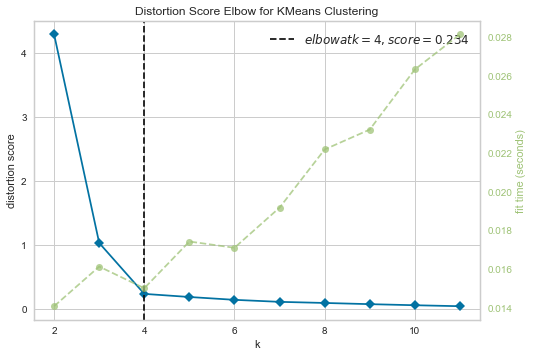

In [31]:
visualizer = KElbowVisualizer(kmeans, k=(2,12))

visualizer.fit(dtf)       
visualizer.show() 